**IMPORTING PACKAGES**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier

**FEATURE BUCKETING**

In [2]:
df = pd.read_csv('DS_reporting_table.csv')
# Get basic statistics of the dataset
print(df.describe())
# Check for missing values
print(df.isnull().sum())

         employeeId  total_feedback_count  average_rating  \
count  25000.000000          25000.000000    25000.000000   
mean     120.553040              5.488040        3.011320   
std       69.019862              2.875807        1.158285   
min        1.000000              1.000000        1.000000   
25%       61.000000              3.000000        2.010000   
50%      120.000000              5.000000        3.010000   
75%      180.000000              8.000000        4.030000   
max      240.000000             10.000000        5.000000   

       total_quizzes_taken   total_score  average_score  total_time_spent  \
count         25000.000000  25000.000000   25000.000000      25000.000000   
mean              5.518720    248.747440      50.002254        266.444920   
std               2.865473    143.965671      28.703062        136.266558   
min               1.000000      0.000000       0.000000         30.000000   
25%               3.000000    124.000000      25.130000        14

In [3]:
# Adjust percentiles to 25th and 75th (or another reasonable boundary)
low_threshold = df['engagement_score'].quantile(0.35)  # 35th percentile
medium_threshold = df['engagement_score'].quantile(0.70)  # 70th percentile

# Create the engagement level column with adjusted thresholds
df['engagement_level'] = pd.cut(df['engagement_score'],
                                bins=[-float('inf'), low_threshold, medium_threshold, float('inf')],
                                labels=['Low', 'Medium', 'High'])

# Validate the new categories
print(df[['employeeId', 'engagement_score', 'engagement_level']])
df

       employeeId  engagement_score engagement_level
0             225            66.150             High
1             160            56.212           Medium
2              85            52.757           Medium
3             209            41.030              Low
4             180            49.601              Low
...           ...               ...              ...
24995          15            29.824              Low
24996         119            47.104              Low
24997         167            68.885             High
24998          69            55.647           Medium
24999         225            69.630             High

[25000 rows x 3 columns]


,employeeId,name_feedback,total_feedback_count,average_rating,name_engagement,department,total_quizzes_taken,total_score,average_score,total_time_spent,engagement_score,engagement_level
0,225,Melissa Galvan,8,4.80,Melissa Galvan,DATA SCIENCE,1,483,54.70,208,66.150,High
1,160,Mary Miller,6,2.44,Mary Miller,FULL STACK,8,209,20.52,402,56.212,Medium
2,85,Patricia Nelson,4,3.35,Patricia Nelson,FULL STACK,9,106,25.17,330,52.757,Medium
3,209,Daniel Lozano,5,1.15,Daniel Lozano,FULL STACK,2,271,52.10,319,41.030,Low
4,180,Jon Hughes,5,3.45,Jon Hughes,DATA SCIENCE,8,40,45.01,185,49.601,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,15,Elizabeth Ayala,4,2.09,Elizabeth Ayala,DATA SCIENCE,4,27,20.04,119,29.824,Low
24996,119,Elizabeth Williams,2,3.99,Elizabeth Williams,DATA ENGINEERING,9,3,81.44,44,47.104,Low
24997,167,Heidi Joyce,5,4.86,Heidi Joyce,DATA ENGINEERING,6,282,85.25,382,68.885,High
24998,69,Andres Vance,2,1.24,Andres Vance,FULL STACK,7,440,69.27,408,55.647,Medium


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   employeeId            25000 non-null  int64   
 1   name_feedback         25000 non-null  object  
 2   total_feedback_count  25000 non-null  int64   
 3   average_rating        25000 non-null  float64 
 4   name_engagement       25000 non-null  object  
 5   department            25000 non-null  object  
 6   total_quizzes_taken   25000 non-null  int64   
 7   total_score           25000 non-null  int64   
 8   average_score         25000 non-null  float64 
 9   total_time_spent      25000 non-null  int64   
 10  engagement_score      25000 non-null  float64 
 11  engagement_level      25000 non-null  category
dtypes: category(1), float64(3), int64(5), object(3)
memory usage: 2.1+ MB


**LABEL ENCODING THE TARGET COLUMN**

In [5]:
# Assume 'engagement_level' is the target column with values 'high', 'medium', 'low'
# Convert the engagement_level categories into numeric values
engagement_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['engagement_level_numeric'] = df['engagement_level'].map(engagement_mapping)

# Now calculate the correlation between numerical columns and the engagement level
# Select only numerical columns including the new 'engagement_level_numeric'
numerical_columns = ['total_feedback_count', 'average_rating', 'total_quizzes_taken', 
                     'total_score', 'average_score', 'total_time_spent', 
                     'engagement_score', 'engagement_level_numeric']

# Compute correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Print correlation of numerical features with 'engagement_level_numeric'
engagement_corr = correlation_matrix['engagement_level_numeric'].sort_values(ascending=False)
print(engagement_corr)

engagement_level_numeric    1.000000
engagement_score            0.900970
total_quizzes_taken         0.452859
total_score                 0.450701
total_feedback_count        0.446316
average_rating              0.345332
average_score               0.206438
total_time_spent            0.197674
Name: engagement_level_numeric, dtype: float64


**VIEWING THE DISTRIBUTION OF TARGET COLUMN**

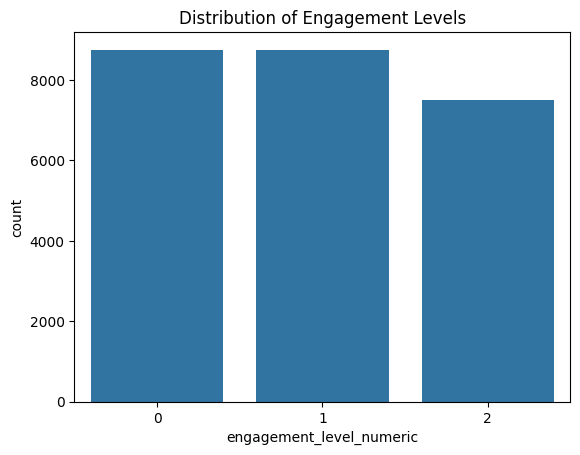

In [6]:


# Visualize the distribution of engagement levels
sns.countplot(x='engagement_level_numeric', data=df)
plt.title('Distribution of Engagement Levels')
plt.show()



**Hypothesis 1: Total Feedback Count Using ANOVA**

In [7]:



# Example for testing Hypothesis 1: Total Feedback Count
low_feedback = df[df['engagement_level_numeric'] == 0]['total_feedback_count']
medium_feedback = df[df['engagement_level_numeric'] == 1]['total_feedback_count']
high_feedback = df[df['engagement_level_numeric'] == 2]['total_feedback_count']

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(low_feedback, medium_feedback, high_feedback)

print("F-statistic:", f_statistic)
print("P-value:", p_value)

# Determine significance
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in total feedback count.")
else:
    print("Fail to reject the null hypothesis: No significant difference in total feedback count.")


F-statistic: 3109.104864799621
P-value: 0.0
Reject the null hypothesis: There is a significant difference in total feedback count.


**Hypothesis 2: Average rating by engagement level**

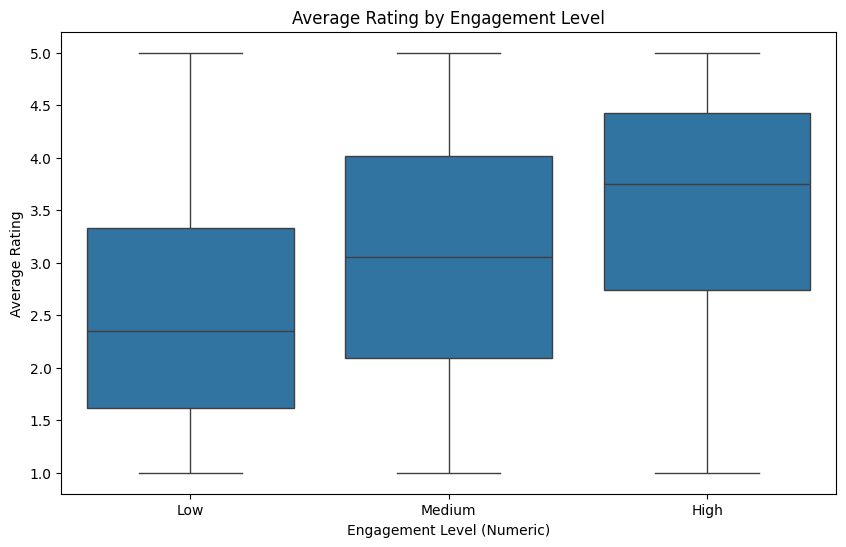

In [8]:
# Hypothesis 2: Average rating by engagement level
plt.figure(figsize=(10, 6))
sns.boxplot(x='engagement_level_numeric', y='average_rating', data=df)
plt.title('Average Rating by Engagement Level')
plt.xlabel('Engagement Level (Numeric)')
plt.ylabel('Average Rating')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.show()

**Hypothesis 3: Total feedback count by engagement level**

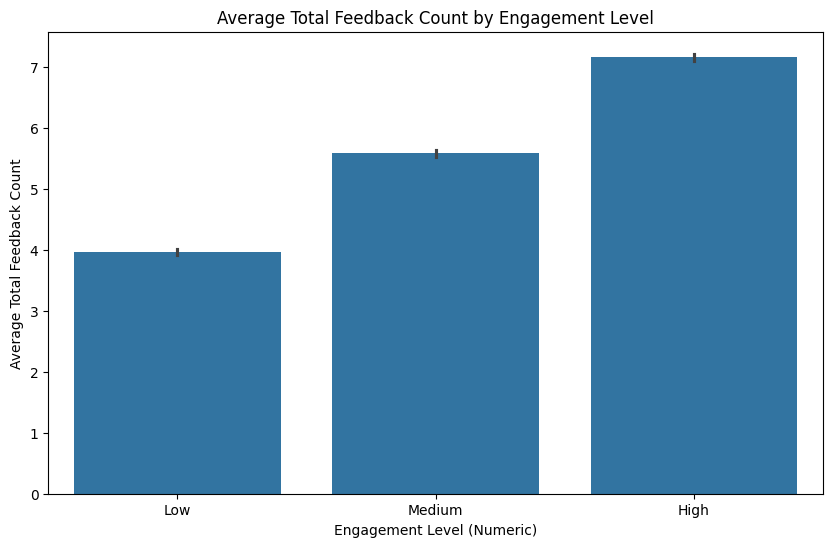

In [9]:
# Hypothesis 3: Total feedback count by engagement level
plt.figure(figsize=(10, 6))
sns.barplot(x='engagement_level_numeric', y='total_feedback_count', data=df, estimator='mean')
plt.title('Average Total Feedback Count by Engagement Level')
plt.xlabel('Engagement Level (Numeric)')
plt.ylabel('Average Total Feedback Count')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.show()

**Hypothesis 4: Total quizzes taken vs. engagement level**

C:\Users\SabareeshwaranM\AppData\Local\Temp\ipykernel_16304\419427951.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quizzes_engagement = df.groupby('engagement_level_numeric')['total_quizzes_taken'].mean().reset_index()


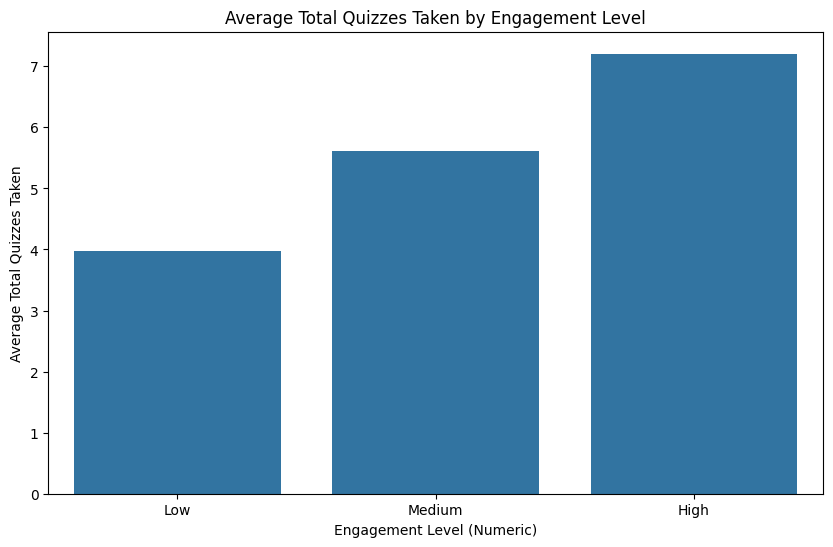

In [10]:
# Hypothesis 4: Total quizzes taken vs. engagement level
plt.figure(figsize=(10, 6))
quizzes_engagement = df.groupby('engagement_level_numeric')['total_quizzes_taken'].mean().reset_index()
sns.barplot(x='engagement_level_numeric', y='total_quizzes_taken', data=quizzes_engagement)
plt.title('Average Total Quizzes Taken by Engagement Level')
plt.xlabel('Engagement Level (Numeric)')
plt.ylabel('Average Total Quizzes Taken')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.show()


**Hypothesis 5: Count of employees by engagement level and department**

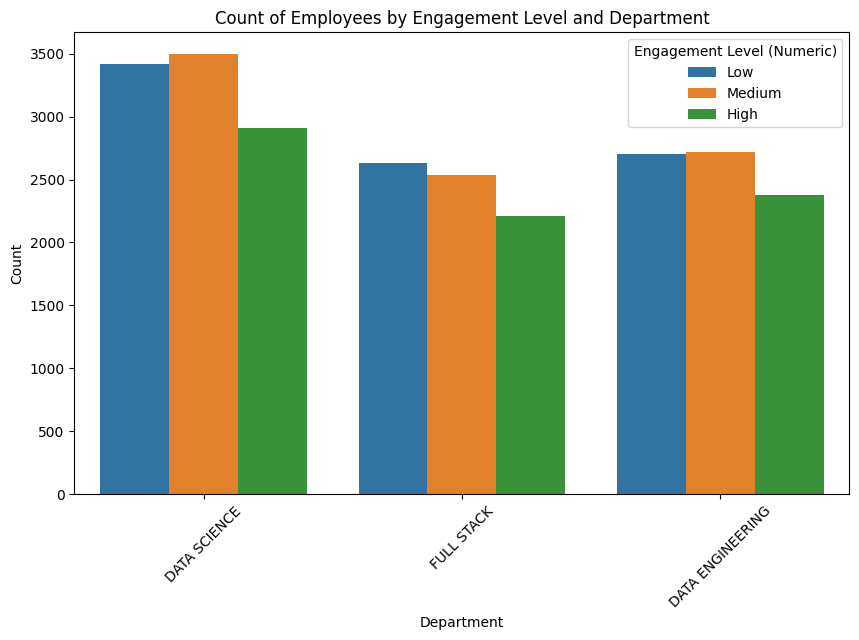

In [11]:
# Hypothesis 5: Count of employees by engagement level and department
plt.figure(figsize=(10, 6))
sns.countplot(x='department', hue='engagement_level_numeric', data=df)
plt.title('Count of Employees by Engagement Level and Department')
plt.xlabel('Department')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Engagement Level (Numeric)', labels=['Low', 'Medium', 'High'])
plt.show()

**Hypothesis 6: Average Total Time Spent by engagement level**

C:\Users\SabareeshwaranM\AppData\Local\Temp\ipykernel_16304\1080863212.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_time_spent = df.groupby('engagement_level_numeric')['total_time_spent'].mean().reset_index()


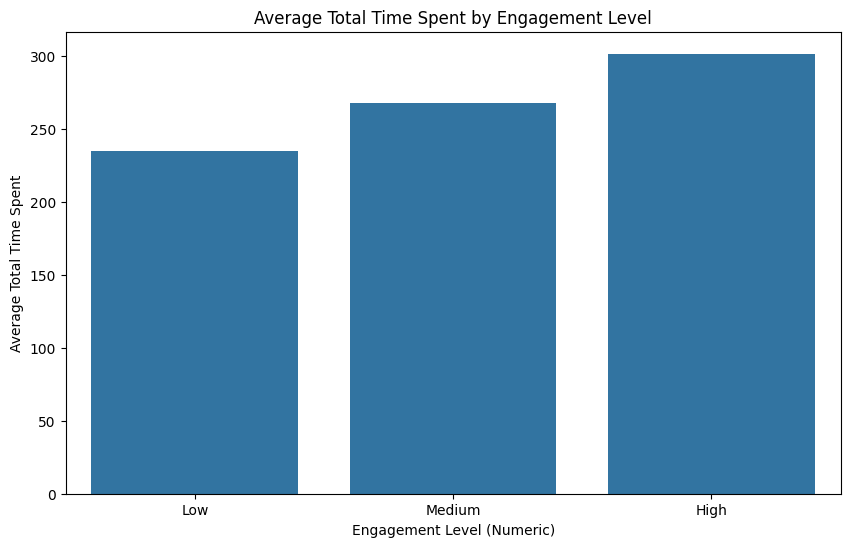

In [12]:
# Hypothesis 6: Average Total Time Spent by engagement level
plt.figure(figsize=(10, 6))
avg_time_spent = df.groupby('engagement_level_numeric')['total_time_spent'].mean().reset_index()
sns.barplot(x='engagement_level_numeric', y='total_time_spent', data=avg_time_spent)
plt.title('Average Total Time Spent by Engagement Level')
plt.xlabel('Engagement Level (Numeric)')
plt.ylabel('Average Total Time Spent')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.show()


**Hypothesis 7: Average score by engagement level**

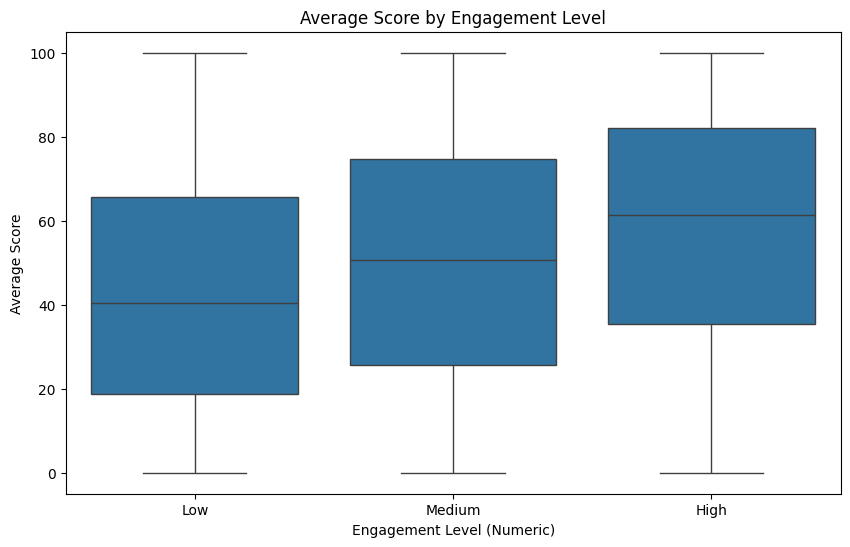

In [13]:
# Hypothesis 7: Average score by engagement level
plt.figure(figsize=(10, 6))
sns.boxplot(x='engagement_level_numeric', y='average_score', data=df)
plt.title('Average Score by Engagement Level')
plt.xlabel('Engagement Level (Numeric)')
plt.ylabel('Average Score')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.show()

**Correlation Matrix**

In [14]:
# Select only numerical columns including 'engagement_level_numeric'
numerical_columns = ['total_feedback_count', 'average_rating', 'total_quizzes_taken', 
                     'total_score', 'average_score', 'total_time_spent', 
                     'engagement_level_numeric']

# Compute the correlation matrix
correlation_matrix = df[numerical_columns].corr()


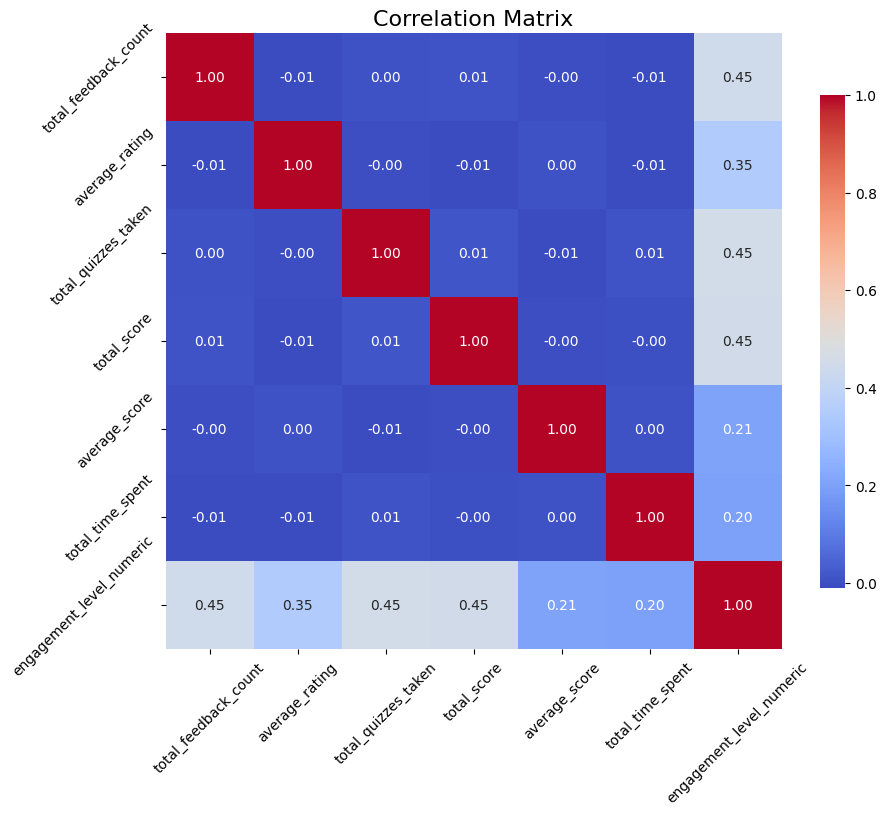

In [15]:


# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title and labels
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


**Training And Testing The Dataset**

In [16]:

# Separate features and target variable
X = df[['total_feedback_count', 'average_rating', 'total_quizzes_taken', 
        'total_score', 'average_score', 'total_time_spent']]  # Features

y = df['engagement_level_numeric']  # Target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Logistic Regression model**

In [17]:


# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Predict the test set results
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1804
           1       0.99      1.00      0.99      1730
           2       1.00      1.00      1.00      1466

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

[[1795    9    0]
 [   1 1725    4]
 [   0    4 1462]]


**Random Forest model with reduced complexity**

In [18]:


# Initialize the Random Forest model with reduced complexity
rf_clf_complexity = RandomForestClassifier(
    random_state=42,
    n_estimators=60,            # Reduce number of trees (default is 100, can tune this)
    max_depth=7,                # Limit the depth of trees to avoid overfitting
    min_samples_split=10,        # Require at least 10 samples to split a node
    min_samples_leaf=5           # Require at least 5 samples at a leaf node
)

# Train the reduced complexity Random Forest model
rf_clf_complexity.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf_complexity = rf_clf_complexity.predict(X_test_scaled)

# Evaluate the model on the test set
print("Random Forest with Reduced Complexity - Test Set Results:")
print(classification_report(y_test, y_pred_rf_complexity))
print(confusion_matrix(y_test, y_pred_rf_complexity))

# Evaluate the model on the training set to check for overfitting
y_train_pred_rf_complexity = rf_clf_complexity.predict(X_train_scaled)
print("\nRandom Forest with Reduced Complexity - Training Set Results:")
print(classification_report(y_train, y_train_pred_rf_complexity))
print(confusion_matrix(y_train, y_train_pred_rf_complexity))


Random Forest with Reduced Complexity - Test Set Results:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1804
           1       0.75      0.81      0.78      1730
           2       0.88      0.84      0.86      1466

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

[[1568  236    0]
 [ 164 1394  172]
 [   0  228 1238]]

Random Forest with Reduced Complexity - Training Set Results:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      6947
           1       0.79      0.86      0.82      7019
           2       0.92      0.86      0.89      6034

    accuracy                           0.87     20000
   macro avg       0.88      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

[[6156  791    0]
 [ 506 6039  474]
 [   0  815 5219]]


In [19]:
report_dict=classification_report(y_test,y_pred,output_dict=True)
report_dict

{'0': {'precision': 0.9994432071269488,
  'recall': 0.9950110864745011,
  'f1-score': 0.9972222222222222,
  'support': 1804.0},
 '1': {'precision': 0.9925201380897584,
  'recall': 0.9971098265895953,
  'f1-score': 0.9948096885813149,
  'support': 1730.0},
 '2': {'precision': 0.9972714870395635,
  'recall': 0.9972714870395635,
  'f1-score': 0.9972714870395635,
  'support': 1466.0},
 'accuracy': 0.9964,
 'macro avg': {'precision': 0.9964116107520903,
  'recall': 0.9964641333678866,
  'f1-score': 0.9964344659477002,
  'support': 5000.0},
 'weighted avg': {'precision': 0.9964110769104595,
  'recall': 0.9964,
  'f1-score': 0.9964019300269127,
  'support': 5000.0}}

**Confusion Matrix For Both Logistic Regression and Random Forest Classifier**

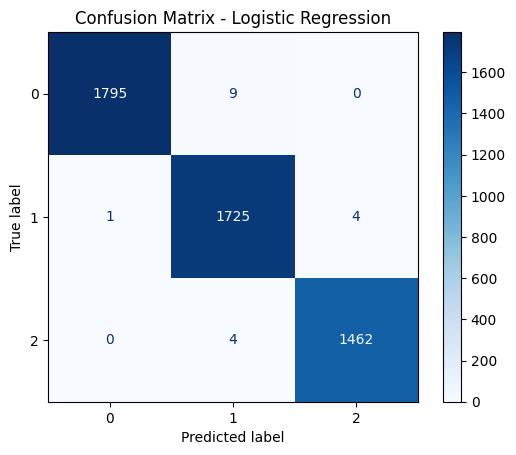

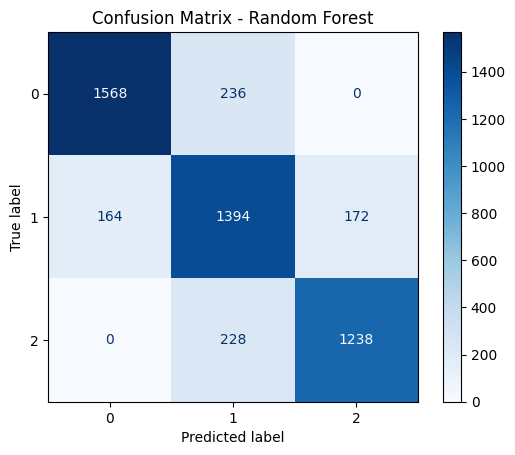

In [20]:


# For Logistic Regression
cm_log_reg = confusion_matrix(y_test, y_pred)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg)
disp_log_reg.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# For Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_complexity)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()



**ROC curve and AUC For RandomForest Classifier**

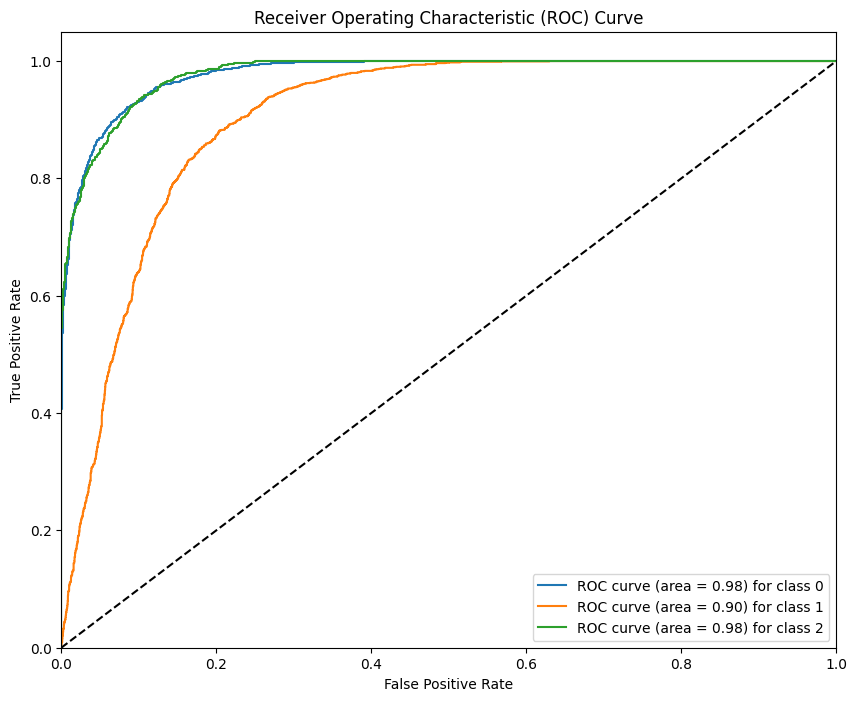

In [21]:


# Binarize the output for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 0, 1, 2 are your classes
n_classes = y_test_binarized.shape[1]

# Predict probabilities for the test set
y_pred_proba = rf_clf_complexity.predict_proba(X_test_scaled)

# Initialize the plot
plt.figure(figsize=(10, 8))

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {i}')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logging the params and metrics in MLFlow**

In [22]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import classification_report, accuracy_score

# Set your MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Replace with your MLflow URI, e.g., "http://localhost:5000" for a local server

# Define a function to log model, parameters, and metrics
def log_model_to_mlflow(model_name, model, X_train, X_test, y_train, y_test):
    with mlflow.start_run(run_name=model_name):
        # Log model parameters
        mlflow.log_param("model_name", model_name)
        if isinstance(model, LogisticRegression):
            mlflow.log_param("solver", model.solver)
            mlflow.log_param("C", model.C)
        elif isinstance(model, RandomForestClassifier):
            mlflow.log_param("n_estimators", model.n_estimators)
            mlflow.log_param("max_depth", model.max_depth)
            mlflow.log_param("min_samples_split", model.min_samples_split)
            mlflow.log_param("min_samples_leaf", model.min_samples_leaf)

        # Train the model
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)

        # Log metrics: Precision, Recall, Accuracy for each class
        for label in ['0', '1', '2']:
            mlflow.log_metric(f"precision_class_{label}", report_dict[label]['precision'])
            mlflow.log_metric(f"recall_class_{label}", report_dict[label]['recall'])

        mlflow.log_metric("accuracy", accuracy)

        # Log the trained model
        mlflow.sklearn.log_model(model, model_name)

        print(f"{model_name} model logged to MLflow with accuracy: {accuracy}")

# Initialize MLflow and set the experiment name
mlflow.set_experiment("Employees Engagement Model")

# Log Logistic Regression model
log_model_to_mlflow(
    model_name="Logistic Regression",
    model=log_reg,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test
)

# Log Random Forest model with reduced complexity
log_model_to_mlflow(
    model_name="Random Forest Classifier",
    model=rf_clf_complexity,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test
)


2024/10/25 10:13:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/25 10:13:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/938085837451351924/runs/f875d62026a945f3ac70115c701f93ee.
2024/10/25 10:13:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/938085837451351924.


Logistic Regression model logged to MLflow with accuracy: 0.9964


2024/10/25 10:14:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/25 10:14:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Classifier at: http://127.0.0.1:5000/#/experiments/938085837451351924/runs/7bb701af320a4ec787ea24daf2b2e4b2.
2024/10/25 10:14:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/938085837451351924.


Random Forest Classifier model logged to MLflow with accuracy: 0.84


**Registering the model**

In [23]:
model_name="Random Forest Classifier"
run_id=input("Enter Run id:")
model_uri=f"runs:/{run_id}/model"
result=mlflow.register_model(
    model_uri,model_name
)

Registered model 'Random Forest Classifier' already exists. Creating a new version of this model...
2024/10/25 10:14:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest Classifier, version 2
Created version '2' of model 'Random Forest Classifier'.


**Loading the Model**

In [24]:
model_uri = 'runs:/012aa3d973a94c9ca26519e6f1c38693/Random Forest Classifier'  # Use the specified run URI

try:
    # Load the model using mlflow.sklearn
    loaded_model = mlflow.sklearn.load_model(model_uri)  # Load directly from the run URI
    print("Model loaded successfully!")
    
    # Test predictions
    y_pred = loaded_model.predict(X_test)
    print("First 4 predictions:", y_pred[:4])

except mlflow.exceptions.MlflowException as e:
    print(f"MLflowException occurred: {str(e)}")
except Exception as e:
    print(f"An error occurred: {str(e)}")



MLflowException occurred: RESOURCE_DOES_NOT_EXIST: Run '012aa3d973a94c9ca26519e6f1c38693' not found


**Transition from dev env to production house**

In [25]:
import mlflow
from mlflow import MlflowClient

# Set the MLflow tracking URI if needed
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Adjust this to your MLflow server URI

# Define your variables
dev_model_uri = 'runs:/012aa3d973a94c9ca26519e6f1c38693'
prod_model_name = 'Employee Engagement Learning-prod'

# Create an MLflow client
client = MlflowClient()

# Register the model version
try:
    result = client.create_registered_model(prod_model_name)  # Register the model if not already done
    print(f"Registered model '{prod_model_name}' created.")
except Exception as e:
    print(f"Model registration error: {str(e)}")

# Now, register the specific version of the model
try:
    model_version = client.create_model_version(
        name=prod_model_name,
        source=dev_model_uri,
        run_id="012aa3d973a94c9ca26519e6f1c38693"  # Your original run ID
    )
    print(f"Model version {model_version.version} registered in '{prod_model_name}'.")
except Exception as e:
    print(f"Error registering model version: {str(e)}")


2024/10/25 10:14:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Employee Engagement Learning-prod, version 2


Model registration error: RESOURCE_ALREADY_EXISTS: Registered Model (name=Employee Engagement Learning-prod) already exists.
Model version 2 registered in 'Employee Engagement Learning-prod'.
